In [1]:
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
import os
from mrcnn.config import Config
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import cv2
import pickle
from PIL import Image
from itertools import product
from skimage.segmentation import find_boundaries
import pandas as pd

Using TensorFlow backend.


In [2]:
import sys
import importlib

In [3]:
sys.path.insert(1, "/Users/dvarelat/Documents/MASTER/TFM/methods")
import cardiac_region
importlib.reload(cardiac_region)
import cardiac_region as c

In [27]:
class CaseConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """

    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NAME = "testing"
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + balloon

    # Number of training steps per epoch
    # STEPS_PER_EPOCH = 1000

    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7

    # 3 si son imagenes en RGB
    # IMAGE_CHANNEL_COUNT = 1

    IMAGE_MAX_DIM = 256
    IMAGE_MIN_DIM = 64

    # El numero de objetos maximo de objetos que se pueden encontrar en una imagen
    TRAIN_ROIS_PER_IMAGE = 256

    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)

    MAX_GT_INSTANCES = 256

    POST_NMS_ROIS_INFERENCE = 2048
    POST_NMS_ROIS_TRAINING = 2048
    RPN_NMS_THRESHOLD = 0.8

In [28]:
m = "mask_rcnn_dapidv_all_0100.h5"
MODEL_DIR = "logs"
config = CaseConfig()
print(config.display())


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

# LOAD ISAAC MODEL

In [29]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model.load_weights(m, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [42]:
folder = "/Users/dvarelat/Documents/MASTER/TFM/DATA/DECON_05/DAPI"
imarray = nib.load(os.path.join(folder, '20190504_E1_DAPI_decon_0.5.nii.gz')).get_fdata() 
imarray = imarray[:,:,:,0]
imarray.shape

(1024, 1024, 413)

In [35]:
slice_ = imarray[:,:,18,0].astype("uint16")
slice_.shape

(1024, 1024)

In [38]:
def tile(img, d):
    w, h, c = img.shape
    grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
    l = []
    for i, j in grid:
        box = (j, i, j+d, i+d)
        l.append(box)
        #l.append(img.crop(box)) 
    crops = {}
    for u,x in enumerate(l):
        crops["{}_{}_{}_{}".format(x[0],x[2],x[1],x[3])] = img[x[0]:x[2], x[1]:x[3]]
    return crops

In [46]:
crops = tile(imarray, 256)
crops.keys()

dict_keys(['0_256_0_256', '256_512_0_256', '512_768_0_256', '768_1024_0_256', '0_256_256_512', '256_512_256_512', '512_768_256_512', '768_1024_256_512', '0_256_512_768', '256_512_512_768', '512_768_512_768', '768_1024_512_768', '0_256_768_1024', '256_512_768_1024', '512_768_768_1024', '768_1024_768_1024'])

## CREATE LIST PICKLE OF PRED

In [47]:
imarray.shape

(1024, 1024, 413)

In [ ]:
results = []
image = cv2.cvtColor(imarray[:,:,i].astype("uint16"), cv2.COLOR_GRAY2RGB)
for i in range(18, 256): ## recorrer slices según margenes lines
    print(i)
    s = cv2.cvtColor(imarray[:,:,i].astype("uint16"), cv2.COLOR_GRAY2RGB)
    crops = tile(s, 256)
    res_crops = []
    for c in crops.keys():
        r = model.detect([crops[c]], verbose=0)
        res_crops.append(r[0])
        print(c)
    results.append(res_crops)
## este results es el pickle 

## predecir un slice

In [61]:
s = cv2.cvtColor(mask_nuclei[:,:, 100].astype("uint16"), cv2.COLOR_GRAY2RGB)
crops = tile(s, 256)
res_crops = []
for c in crops.keys():
    r = model.detect([crops[c]], verbose=0)
    res_crops.append(r[0])
    print(c)

0_256_0_256
256_512_0_256
512_768_0_256
768_1024_0_256
0_256_256_512
256_512_256_512
512_768_256_512
768_1024_256_512
0_256_512_768
256_512_512_768
512_768_512_768
768_1024_512_768
0_256_768_1024
256_512_768_1024
512_768_768_1024
768_1024_768_1024


In [62]:
### para un slice
R = [i for i,r in enumerate(res_crops) if r["masks"].shape[2] != 0 ]
results_good = {list(crops.keys())[i]:res_crops[i] for i in R}
results_good.keys()

dict_keys(['256_512_0_256', '256_512_256_512', '256_512_512_768', '512_768_512_768'])

## REVISAR POR CROPS

In [56]:
k ='0_256_512_768'
x = results_good[k]["masks"]
if x.shape[2] >1 :
    print(x.shape)
    x = np.sum(results_good[k]["masks"], axis=2)
    x = x.reshape((256, 256))
print(x.shape)

KeyError: '0_256_512_768'

(256, 256)


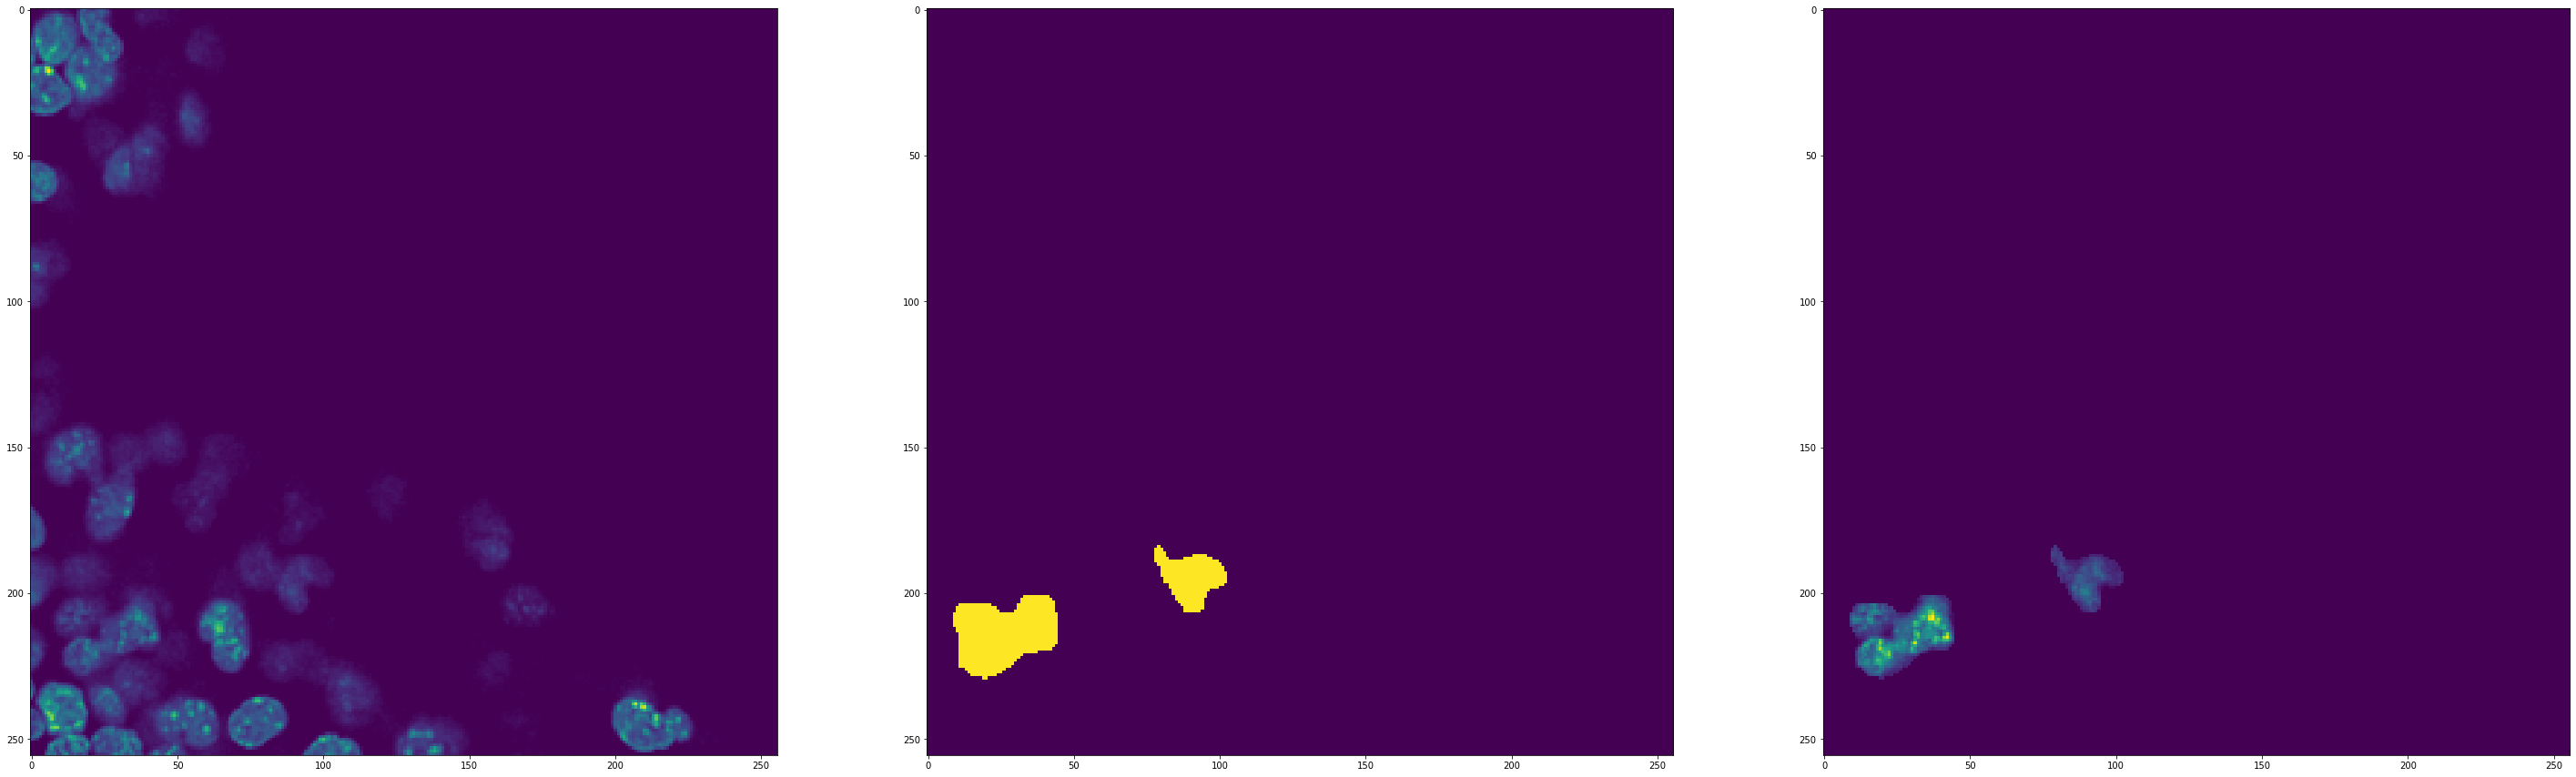

In [352]:
CROP  = cv2.cvtColor(crops[k], cv2.COLOR_BGR2GRAY)
mask = np.where(x == 1, 1,0)
print(mask.shape)
plt.figure(figsize=(50,50)) 
plots = [CROP, x, (CROP*mask)]
for i in range(len(plots)):
    plt.subplot(1,len(plots), i+1)
    plt.imshow(plots[i])

## revisar Todo el slice

In [63]:
prediction = np.zeros((1024,1024))
for k in results_good.keys():
    x = results_good[k]["masks"]
    if x.shape[2] >1 :
        print(x.shape)
        x = np.sum(results_good[k]["masks"], axis=2)
    x = x.reshape((256, 256))     
    print(x.shape)
    kk = k.split("_")
    kk = [int(i) for i in kk]
    print(prediction[kk[0]:kk[1], kk[2]:kk[3]].shape)
    prediction[kk[0]:kk[1], kk[2]:kk[3]] = x

(256, 256, 2)
(256, 256)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256)
(256, 256, 3)
(256, 256)
(256, 256)
(256, 256, 2)
(256, 256)
(256, 256)


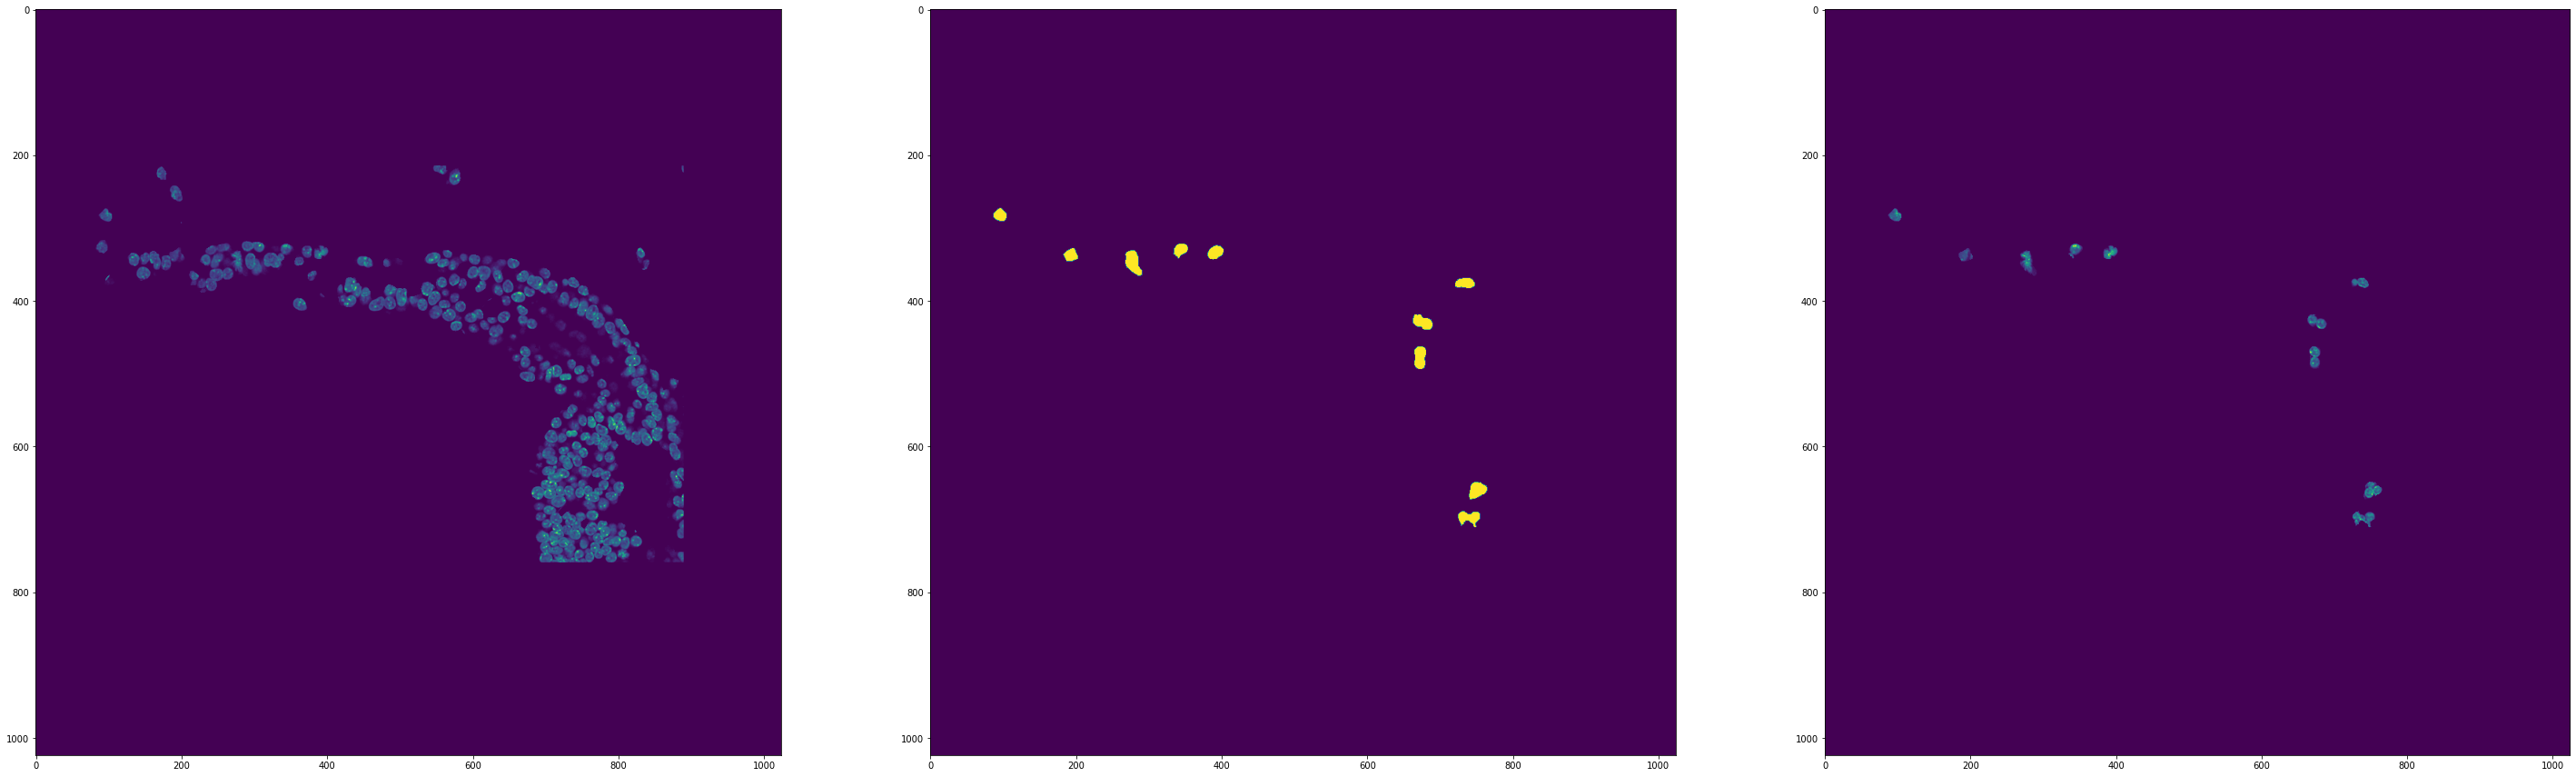

In [64]:
plt.figure(figsize=(50,50)) 
sgray = cv2.cvtColor(s, cv2.COLOR_BGR2GRAY)
plots = [sgray, prediction, (sgray*prediction)]
for i in range(len(plots)):
    plt.subplot(1,len(plots), i+1)
    plt.imshow(plots[i])

# FULL INFERENCE

In [4]:
inf = "/Users/dvarelat/Documents/MASTER/TFM/methods/division/INFERENCE/20190504_E1_inference.pkl"
file ="/Users/dvarelat/Documents/MASTER/TFM/DATA/DECON_05/DAPI/20190504_E1_DAPI_decon_0.5.nii.gz"

In [5]:
imarray = nib.load(file).get_fdata() 
imarray.shape

(1024, 1024, 413, 1)

In [12]:
w, h = 1024, 1024
d = 256
grid = product(range(0, h-h%d, d), range(0, w-w%d, d))
keys = []
for i, j in grid:
    box = (j, i, j+d, i+d)
    keys.append("{}_{}_{}_{}".format(box[0],box[2],box[1],box[3]))

In [6]:
with open(inf, 'rb') as f:
    list_inf = pickle.load(f)

In [7]:
len(list_inf)

238

In [62]:
z = 150
zreal = z + zini
print(zreal)
res_crops = list_inf[z] # de un solo slice
sgray = imarray[:,:,zreal,0].astype("uint16")
sgray.shape

168


(1024, 1024)

In [63]:
R = [i for i,r in enumerate(res_crops) if r["masks"].shape[2] != 0 ]
results_good = {keys[i]:res_crops[i] for i in R}
results_good.keys()

dict_keys(['0_256_0_256', '256_512_0_256', '512_768_0_256', '768_1024_0_256', '0_256_256_512', '256_512_256_512', '512_768_256_512', '768_1024_256_512', '0_256_512_768', '256_512_512_768', '512_768_512_768', '0_256_768_1024', '256_512_768_1024', '512_768_768_1024', '768_1024_768_1024'])

In [87]:
prediction = np.zeros((1024,1024))
for k in results_good.keys():
    print(k)
    x = results_good[k]["masks"]
    if x.shape[2] >1 :
        x = np.sum(results_good[k]["masks"], axis=2)
    x = x.reshape((256, 256))     
    kk = k.split("_")
    kk = [int(i) for i in kk]
    prediction[kk[0]:kk[1], kk[2]:kk[3]] = x

0_256_0_256
256_512_0_256
512_768_0_256
768_1024_0_256
0_256_256_512
256_512_256_512
512_768_256_512
768_1024_256_512
0_256_512_768
256_512_512_768
512_768_512_768
0_256_768_1024
256_512_768_1024
512_768_768_1024
768_1024_768_1024


In [ ]:
plt.figure(figsize=(50,50)) 
plots = [sgray, prediction, (sgray*prediction) , sgray + 100*find_boundaries(prediction)]
for i in range(len(plots)):
    plt.subplot(1,len(plots), i+1)
    plt.imshow(plots[i])

# create prediction mask

In [10]:
print(imarray.shape)
zini = 18
zfin = 256

(1024, 1024, 413, 1)


In [13]:
list_masks = []
for z in range(len(list_inf)):
    print(z)
    zreal = z + zini
    sgray = imarray[:,:,zreal,0].astype("uint16")
    print(sgray.shape)
    res_crops = list_inf[z]
    R = [i for i,r in enumerate(res_crops) if r["masks"].shape[2] != 0 ]
    print(R)
    results_good = {keys[i]:res_crops[i] for i in R}
    prediction = np.zeros((1024,1024))
    for k in results_good.keys():
        x = results_good[k]["masks"]
        if x.shape[2] >1 :
            x = np.sum(results_good[k]["masks"], axis=2)
        x = x.reshape((256, 256)) 
        kk = k.split("_")
        kk = [int(i) for i in kk]
        prediction[kk[0]:kk[1], kk[2]:kk[3]] = x
    list_masks.append(prediction)
    print("..........")

0
(1024, 1024)
[]
..........
1
(1024, 1024)
[]
..........
2
(1024, 1024)
[]
..........
3
(1024, 1024)
[]
..........
4
(1024, 1024)
[]
..........
5
(1024, 1024)
[]
..........
6
(1024, 1024)
[]
..........
7
(1024, 1024)
[]
..........
8
(1024, 1024)
[]
..........
9
(1024, 1024)
[]
..........
10
(1024, 1024)
[4]
..........
11
(1024, 1024)
[4, 9]
..........
12
(1024, 1024)
[4, 9]
..........
13
(1024, 1024)
[4, 9]
..........
14
(1024, 1024)
[4, 9, 13]
..........
15
(1024, 1024)
[4]
..........
16
(1024, 1024)
[4]
..........
17
(1024, 1024)
[4]
..........
18
(1024, 1024)
[4, 9]
..........
19
(1024, 1024)
[9]
..........
20
(1024, 1024)
[]
..........
21
(1024, 1024)
[]
..........
22
(1024, 1024)
[]
..........
23
(1024, 1024)
[9]
..........
24
(1024, 1024)
[9, 13]
..........
25
(1024, 1024)
[13]
..........
26
(1024, 1024)
[9, 13]
..........
27
(1024, 1024)
[]
..........
28
(1024, 1024)
[9, 13]
..........
29
(1024, 1024)
[13]
..........
30
(1024, 1024)
[13]
..........
31
(1024, 1024)
[9, 13]
.....

(1024, 1024)
[2, 5, 6, 9, 10, 13]
..........
210
(1024, 1024)
[2, 6, 9, 10, 13]
..........
211
(1024, 1024)
[2, 5, 6, 9]
..........
212
(1024, 1024)
[2, 6, 9, 10]
..........
213
(1024, 1024)
[2, 5, 6, 9, 10]
..........
214
(1024, 1024)
[2, 5, 6, 9, 10]
..........
215
(1024, 1024)
[2, 5, 6, 9, 10]
..........
216
(1024, 1024)
[2, 5, 6, 9, 10]
..........
217
(1024, 1024)
[5, 6, 9, 10]
..........
218
(1024, 1024)
[2, 5, 6, 9, 10]
..........
219
(1024, 1024)
[2, 5, 6, 9, 10, 13]
..........
220
(1024, 1024)
[5, 6, 9, 10, 13]
..........
221
(1024, 1024)
[2, 6, 9, 10]
..........
222
(1024, 1024)
[2, 6, 9, 10, 13]
..........
223
(1024, 1024)
[2, 5, 6, 10]
..........
224
(1024, 1024)
[2, 5, 6, 10]
..........
225
(1024, 1024)
[2, 6, 9, 10]
..........
226
(1024, 1024)
[2, 5, 6, 10]
..........
227
(1024, 1024)
[2, 5, 6, 10]
..........
228
(1024, 1024)
[]
..........
229
(1024, 1024)
[]
..........
230
(1024, 1024)
[]
..........
231
(1024, 1024)
[]
..........
232
(1024, 1024)
[]
..........
233
(1024, 

In [14]:
full_list_masks= [np.zeros((1024,1024)) for i in range(zini)] + list_masks + [np.zeros((1024,1024)) for i in range(imarray.shape[2] - zfin)]

In [15]:
pred_div = np.swapaxes(np.swapaxes(np.array(full_list_masks), 0, 2), 0, 1)
pred_div.shape

(1024, 1024, 413)

In [16]:
c.saveNifti(pred_div, {"x_res":0,"y_res":0, "z_res":0}, 
            f"/Users/dvarelat/Documents/MASTER/TFM/methods/division/INFERENCE/20190504_E1_predmask.nii.gz")

In [65]:
prediction_mask = prediction

# Find membranes

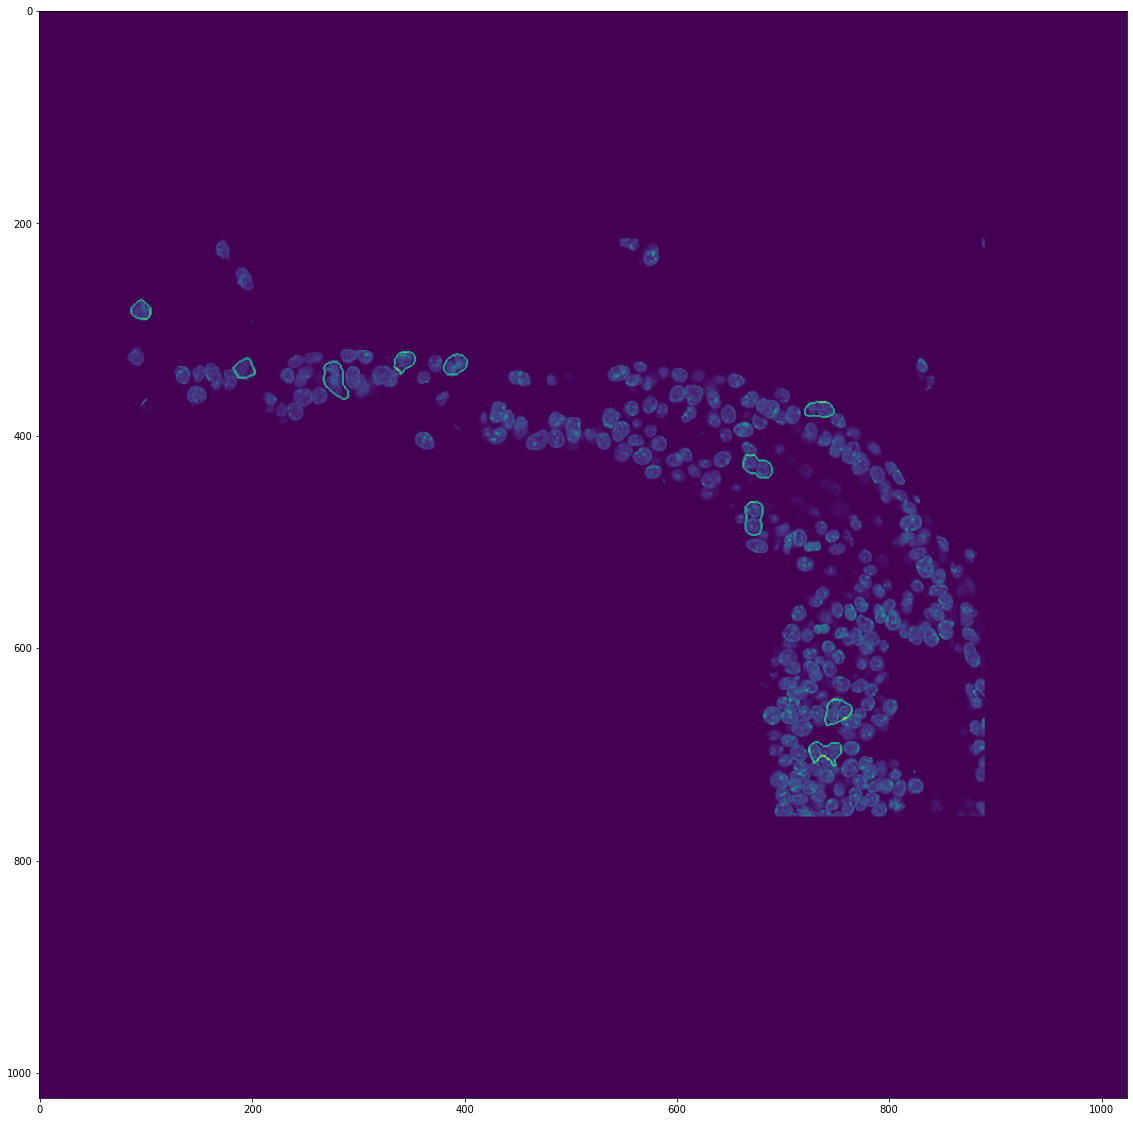

In [72]:
plt.figure(figsize=(20,20)) 
plt.imshow(mask_nuclei[:,:,100] + 100*find_boundaries(prediction_mask))